In [1]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
import dill
import pickle as pkl
import sys
sys.path.append('../')

from hyperneat.hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import DynamicObstacleTraverser


import itertools as it
import time
import imageio

from matplotlib import pyplot as plt


from sgr.substrates import morph_substrate, control_substrate
from sgr.generate_robot import generate_robot, eval_robot_constraint
from sgr.evogym_sim import simulate_env
from sgr.body_speciation import CustomGenome
from copy import deepcopy

In [2]:
def get_robot(genome, robot_size, neat_config, env_config):
    if genome.robot is not None:
        robot = genome.robot
    else:
        cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)
        design_substrate = morph_substrate(robot_size)
        design_net = create_phenotype_network(cppn, design_substrate)
        robot = generate_robot(design_net, robot_size)
        print(robot)

    if not eval_robot_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)

    
    env = DynamicObstacleTraverser(body=robot, connections=connections, env_config=env_config)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [3]:
with open(f"../checkpoints/new_cppn_1/cp_5.pkl", "rb") as file:
    poet_pop = pkl.load(file)
    
CustomGenome.robot_func = lambda self, net, config: generate_robot(net, poet_pop.run_params.robot_size)
CustomGenome.substrate = morph_substrate(poet_pop.run_params.robot_size, poet_pop.run_params.substrate_type)
CustomGenome.robot_size = poet_pop.run_params.robot_size
CustomGenome.spec_genotype_weight = poet_pop.run_params.spec_genotype_weight
CustomGenome.spec_phenotype_weight = poet_pop.run_params.spec_phenotype_weight

In [4]:
def show_img(ag, min_fit, robot_size, neat_config, env_config):
    if ag.fitness is not None and ag.fitness > min_fit:
        r, img = get_robot(ag, robot_size, neat_config, env_config)
        if img is not None:
            print(ag.key, ag.fitness)
            print(ag.robot)
            plt.imshow(img)
            plt.show()
            cppn = neat.nn.FeedForwardNetwork.create(ag, neat_config)
            
            design_substrate = morph_substrate(robot_size, poet_pop.run_params.substrate_type)
            controller_substrate = control_substrate(robot_size, "dynamic", ag.robot, poet_pop.run_params.substrate_type)

            print(len(controller_substrate.input_coordinates))
            print(poet_pop.run_params.substrate_type)
            
            design_net = create_phenotype_network(cppn, design_substrate, output_node_idx=0)
            controller_net = create_phenotype_network(cppn, controller_substrate, output_node_idx=1)

            print("CPPN")
            display(draw_net(cppn))
            print("Controller:")
            display(draw_net(controller_net))
            print("Morphology:")
            display(draw_net(design_net))




###################### Pair (env: 0, pop: 0) ########################

------------- Champion ----------------
147 2.7166515961415154
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4.]
 [0. 0. 0. 4. 4.]
 [0. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4.]]


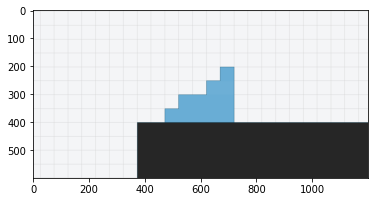

16
cppn
CPPN


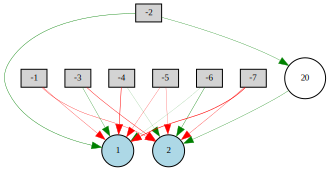

Controller:


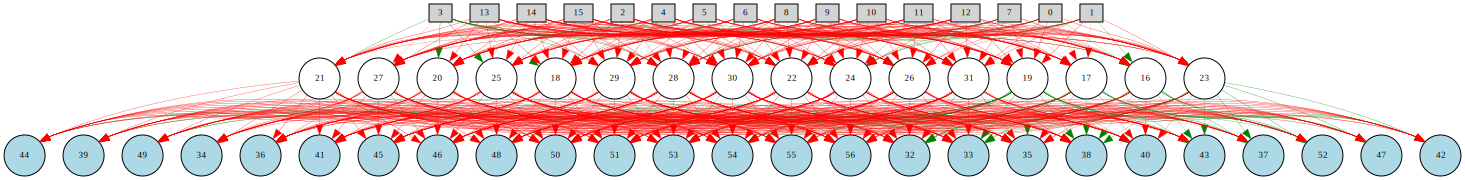

Morphology:


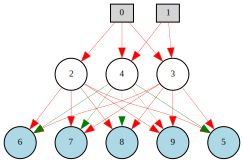

In [5]:
for p in poet_pop.pairs:
    pop = p.agent_pop
    env = p.environment
    print(f"\n\n###################### Pair (env: {env.id}, pop: {pop.id}) ########################\n")
    
    # for ag_id, ag in pop.pop.population.items():
    #     show_img(ag, 1.5, pop.robot_size, pop.neat_config, env)
    
    print("------------- Champion ----------------")
    show_img(pop.pop.best_genome, -1, pop.robot_size, pop.neat_config, env)


In [6]:
STEPS = 600
env_dict = {}
ag_dict = {}
for p in poet_pop.pairs:
    pop = p.agent_pop
    env = p.environment
    for ag_id, ag in pop.pop.population.items():
        ag_dict[ag_id] = (ag, pop)
    env_dict[env.id] = env



In [7]:
def show_exec(ag_id, env_id):
    ag, pop = ag_dict[ag_id]
    
    print(ag.robot)
    reward, done = pop.single_genome_fit(ag, STEPS, "dynamic", env_dict[env_id], True, None)
    return reward, done

In [8]:
r, d = show_exec(190, 0)
print(r)

[[0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 0. 4. 4.]
 [0. 0. 4. 4. 4.]
 [0. 0. 4. 4. 4.]]
7.33105950674838


In [72]:
env = deepcopy(env_dict[6])
env.heights_list

array([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 11,  9,  9,  9,  9,  8,
       11,  9,  9,  9, 10,  9,  8,  8,  9, 10,  9, 11, 11, 10, 11,  8, 11,
        8,  8,  9,  9,  9,  9,  8, 10,  8,  7,  9,  9, 10,  9,  9, 10, 11,
       10,  8,  8, 10, 10,  9,  9,  9, 10,  7,  7,  9, 10,  8,  9,  9,  8,
       10,  7,  9,  9, 10,  8,  7,  9,  9, 10,  9,  8, 10,  9,  9,  8, 10,
        8, 10,  9,  9, 10])

In [29]:
previous_h = 9
for idx, h in enumerate(env.heights_list):
    if idx < env.flat_start:
        pass 
    elif env.rng.random() < .4: 
        r = env.rng.random()

        if r < .05:
            h -= 3
        elif r < .15:
            h -= 2
        elif r < .5:
            h -= 1
        elif r < .85:
            h += 1
        elif r < .95:
            h += 2
        else:
            h += 3
            
    h = np.clip(h, 0, env.h)
    h = np.clip(h, previous_h-2, previous_h+2)
    env.heights_list[idx] = h
    previous_h = h

0
0
0
0
0
0
0
0
0
0
-2
2
0
-2
0
2
-1
2
-2
1
-2
2
2
-2
1
0
0
2
-1
1
-2
2
-2
2
-2
0
-2
2
0
0
-1
2
1
-2
-2
2
-1
1
-1
2
1
-2
-1
-2
1
2
0
-2
2
-1
-2
2
0
1
-1
-1
0
-2
2
-1
1
2
0
1
-2
0
2
-1
-2
-1
2
0
1
-2
1
-2
2
-2
2
1


In [23]:
env.heights_list

array([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  7,  9,  9,  7,  7,  9,  8,
       10,  8,  9,  7,  9, 11,  9, 10, 10, 10, 12, 11, 12, 10, 12, 10, 12,
       10, 10,  8, 10, 10, 10,  9, 11, 12, 10,  8, 10,  9, 10,  9, 11, 12,
       10,  9,  7,  8, 10, 10,  8, 10,  9,  7,  9,  9, 10,  9,  8,  8,  6,
        8,  7,  8, 10, 10, 11,  9,  9, 11, 10,  8,  7,  9,  9, 10,  8,  9,
        7,  9,  7,  9, 10])